In [1]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#              https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
import json 
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
# encode text category labels
from sklearn.preprocessing import LabelEncoder

In [2]:
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def toString(arr):
  return [str(elem) for elem in arr]

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Memes Project/dank_image_downloaded.csv")
df['ups_normed'] = df['ups']/df['subscribers']

value = df['ups_normed'].quantile(0.95)
df['dank_level'] = df['ups_normed'].apply(lambda x: 1 if x >= value else 0)

def getDankLevel(imageLink):
  imgID = imageLink.split('/')[-1].split('.')[0] #find image id based on the file name
  return list(df.loc[df['id'] == imgID]['dank_level'])[0] #look up the dank_level based on the image id

data = '/content/gdrive/My Drive/Colab Notebooks/Memes Project/data'
train_files = glob.glob(data + '/training/*.jpg')
validation_files = glob.glob(data + '/validation/*.jpg')
test_files = glob.glob(data + '/test/*.jpg')
print("Training: {} imgs, Validation: {} imgs, Test: {} imgs".format(len(train_files), len(validation_files), len(test_files)))

IMG_DIM = (299, 299)
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
"""
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
"""
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

"""
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255 
"""

train_labels = [getDankLevel(fn) for fn in train_files]
validation_labels = [getDankLevel(fn) for fn in validation_files]
#test_labels = [getDankLevel(fn) for fn in test_files]

print("Generated the labels ", train_labels[0:5], " ", validation_labels[0:5])

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
#test_labels_enc = le.transform(test_labels)

print("Encoded the labels ", train_labels_enc[0:5], " ", validation_labels_enc[0:5])

# Image Augmentation generator to create variety of images
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                  width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                  horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)  

print("Created the generator")   

Training: 3712 imgs, Validation: 1856 imgs, Test: 1858 imgs
Train dataset shape: (3712, 299, 299, 3) 	Validation dataset shape: (1856, 299, 299, 3)
Generated the labels  [0, 0, 0, 0, 0]   [0, 0, 0, 0, 0]
Encoded the labels  [0 0 0 0 0]   [0 0 0 0 0]
Created the generator


In [6]:
"""        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   
"""

"        \nlayers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]\npd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   \n"

In [19]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

inception = inception_v3.InceptionV3(include_top=False, weights='imagenet', 
                                     input_shape=(299, 299, 3))

output = inception.layers[-1].output
output = keras.layers.Flatten()(output)
inception_model = Model(inception.input, output)

last_layer = inception_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
for (index, layer) in enumerate(inception_model.layers):
  if layer == last_layer:
    last_layer_loc = index

inception_model.trainable = True
for layer in inception_model.layers[:last_layer_loc]:
    layer.trainable = False  

layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(20)   

last layer output shape:  (None, 17, 17, 768)


,Layer Type,Layer Name,Layer Trainable
292,<tensorflow.python.keras.layers.convolutional....,conv2d_938,True
293,<tensorflow.python.keras.layers.pooling.Averag...,average_pooling2d_89,True
294,<tensorflow.python.keras.layers.convolutional....,conv2d_931,True
295,<tensorflow.python.keras.layers.normalization_...,batch_normalization_933,True
296,<tensorflow.python.keras.layers.normalization_...,batch_normalization_934,True
297,<tensorflow.python.keras.layers.normalization_...,batch_normalization_937,True
298,<tensorflow.python.keras.layers.normalization_...,batch_normalization_938,True
299,<tensorflow.python.keras.layers.convolutional....,conv2d_939,True
300,<tensorflow.python.keras.layers.normalization_...,batch_normalization_931,True
301,<tensorflow.python.keras.layers.core.Activatio...,activation_933,True


In [20]:
input_shape = inception_model.output_shape[1]

model = Sequential()
model.add(inception_model)
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(1024, activation='relu', input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

# to prevent over fitting training will stop after 20 epochs if val_loss value not decreased
earlystop = EarlyStopping(patience=20)
# reduce the learning rate when then accuracy not increases for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.75, 
                                            min_lr=1e-20)
callbacks = [earlystop, learning_rate_reduction]

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=100, 
                              validation_data=val_generator, validation_steps=STEP_SIZE_VALID, callbacks=callbacks, verbose=1)     

Epoch 1/100
123/123 [==============================] - 113s 916ms/step - loss: 1.4222 - accuracy: 0.5128 - val_loss: 0.6965 - val_accuracy: 0.5245
Epoch 2/100
123/123 [==============================] - 110s 897ms/step - loss: 0.7204 - accuracy: 0.5239 - val_loss: 0.6726 - val_accuracy: 0.5793
Epoch 3/100
123/123 [==============================] - 111s 905ms/step - loss: 0.6885 - accuracy: 0.5856 - val_loss: 0.6934 - val_accuracy: 0.5663
Epoch 4/100
123/123 [==============================] - 110s 892ms/step - loss: 0.6590 - accuracy: 0.6304 - val_loss: 0.6877 - val_accuracy: 0.6005
Epoch 5/100
123/123 [==============================] - 107s 871ms/step - loss: 0.6281 - accuracy: 0.6608 - val_loss: 0.6801 - val_accuracy: 0.5772
Epoch 6/100
123/123 [==============================] - 110s 894ms/step - loss: 0.5967 - accuracy: 0.6833 - val_loss: 0.7560 - val_accuracy: 0.5701
Epoch 7/100
123/123 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7194
Epoch 00007: ReduceLR

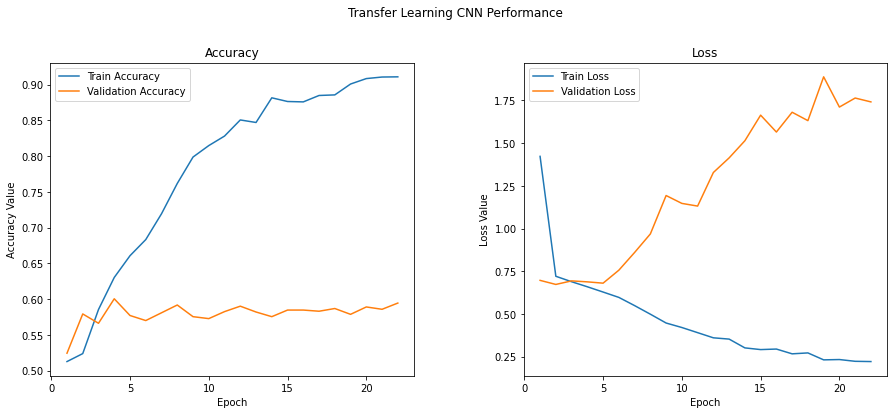

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Transfer Learning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

iterations = len(history.history['accuracy'])
epoch_list = list(range(1,iterations+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
#ax1.set_xticks(np.arange(0, 49, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
#ax2.set_xticks(np.arange(0, 49, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
results = {}
results['epoch_list'] = epoch_list
results['accuracy'] = toString(history.history['accuracy'])
results['val_accuracy'] = toString(history.history['val_accuracy'])
results['val_loss'] = toString(history.history['val_loss'])
results['loss'] = toString(history.history['loss'])

In [24]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Memes Project/best models/finetune_img_aug_inception_lr_big_set.h5')

In [25]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/best models/finetune_img_aug_inception_lr_big_set_results.json', 'w') as outfile:
  json.dump(results, outfile)

In [26]:
test_files = glob.glob(data + '/test/*.jpg')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255 

test_labels = [getDankLevel(fn) for fn in test_files]
test_labels_enc = le.transform(test_labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [27]:
print("Evaluation of model:")
print(model.evaluate(test_imgs_scaled, test_labels_enc))

Evaluation of model:
59/59 [==============================] - 17s 283ms/step - loss: 1.7583 - accuracy: 0.5684
[1.7582927942276, 0.5683530569076538]
